In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


#3.2 — Carregar o dataset limpo

In [2]:
df = pd.read_csv("../data/students_clean.csv")
df = df.dropna()
df.head()


,video_id,duration_minutes,title_length,description_length,tags_count,has_thumbnail_custom,video_quality,category,language,has_subtitles,...,comments_count,likes_count,shares_count,playlist_adds,promoted,upload_time,upload_day,total_views,duration_minutes_log,tags_count_log
2,VID01091,47,-0.744253,-1.346645,20.0,0,0,Gaming,Espanhol,Não,...,6943.0,34028,542.0,540,Não,Manhã,Seg-Qui,1420456,0.815401,0.077487
3,VID00388,8,-1.624473,-1.010156,4.0,1,0,Tecnologia,Português,Sim,...,9427.0,42695,3096.0,188,Não,Madrugada,Sábado,329746,-1.471798,-1.554673
4,VID02222,56,1.513703,0.408954,48.0,0,4,Vlogs,Espanhol,Não,...,2993.0,40761,311.0,957,Não,Manhã,Domingo,984985,1.050205,1.041142
5,VID00169,16,1.666785,-1.617300,1.0,1,4,Educação,Português,Não,...,5108.0,33562,4814.0,821,Não,Manhã,Domingo,266178,-0.602829,-2.596795
6,VID01379,34,1.590244,-0.388381,26.0,1,1,Vlogs,Português,Sim,...,5518.0,33442,1515.0,960,Não,Madrugada,Sábado,555307,0.383843,0.363314


#3.3 — Separar features e target

Estamos prevendo total_views, então ele vira o alvo (y), e o resto das colunas viram os atributos (X).

In [3]:
df_model = df.drop(columns=["video_id"])

X = df_model.drop(columns=["total_views"])
y = df_model["total_views"]

#3.4 — Divisão dos dados (60/20/20)

Primeiro separamos teste (20%).
Depois dividimos o restante em treino (60%) e validação (20%).

In [4]:
# 1º split: treino (60%) e restante (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42
)

# 2º split: validação (20%) e teste (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

#3.5 — Criando e treinando o modelo Baseline

Categóricas viram números com OneHotEncoder.
O modelo baseline é Regressão Linear, simples e interpretável.

In [5]:
# identificar colunas
categorical_cols = X.select_dtypes(include=["object"]).columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns

# pipeline de transformação
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

# transformar
X_train_t = preprocess.fit_transform(X_train)
X_val_t = preprocess.transform(X_val)
X_test_t = preprocess.transform(X_test)

# modelo baseline
model = LinearRegression()
model.fit(X_train_t, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


#3.6 — Avaliação do modelo (treino e validação)

Calculamos todas as métricas obrigatórias (MSE, RMSE, MAE, R²) para comparar treino vs validação e identificar possíveis sinais de overfitting.

In [6]:
# predições
train_pred = model.predict(X_train_t)
val_pred = model.predict(X_val_t)

# métricas
def calc_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

rmse_train, r2_train = calc_metrics(y_train, train_pred)
rmse_val, r2_val = calc_metrics(y_val, val_pred)

print("TREINO → RMSE:", rmse_train, " | R²:", r2_train)
print("VALIDAÇÃO → RMSE:", rmse_val, " | R²:", r2_val)


TREINO → RMSE: 478091.9965529531  | R²: 0.5710774315178186
VALIDAÇÃO → RMSE: 478596.25958482904  | R²: 0.42213471241284506


#3.7 — Gráfico: Predições vs Valores Reais

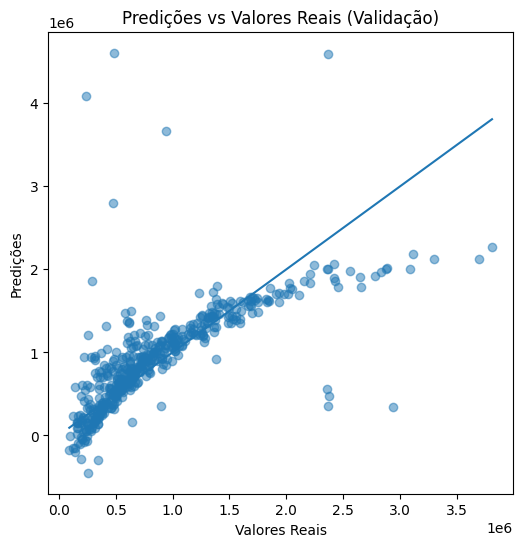

In [7]:
plt.figure(figsize=(6,6))
plt.scatter(y_val, val_pred, alpha=0.5)
plt.xlabel("Valores Reais")
plt.ylabel("Predições")
plt.title("Predições vs Valores Reais (Validação)")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()])
plt.show()


Esse gráfico mostra os pontos reais (eixo X) contra as predições feitas pelo modelo (eixo Y).

Como interpretar:

Se o modelo fosse perfeito, os pontos ficariam em uma linha diagonal.

Quanto mais espalhados estiverem, pior o modelo está prevendo.

Ele serve para identificar:

✔ alinhamento das predições
✔ tendência de erro
✔ padrões de subestimação ou superestimação

#3.8 — Distribuição dos resíduos

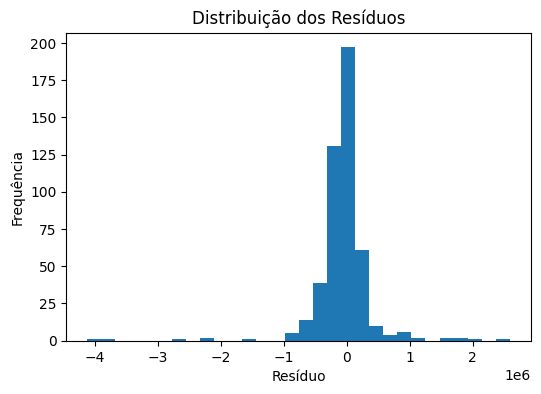

In [8]:
residuals = y_val - val_pred

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.title("Distribuição dos Resíduos")
plt.xlabel("Resíduo")
plt.ylabel("Frequência")
plt.show()


Resíduos = erro da previsão.

O gráfico mostra como os erros estão distribuídos.

Um bom modelo deveria ter resíduos:

distribuídos simetricamente

média próxima de zero

sem caudas pesadas (igual a uma distribuição normal)

Se houver curva torta ou caudas grandes → indica que o modelo não está capturando bem o padrão dos dados.

#3.9 — Importância das Features

Coeficientes positivos aumentam o total de views, negativos diminuem.
Mostra os 10 atributos mais relevantes da regressão.

In [9]:
# pegar nomes das colunas após o OneHotEncoder
feature_names = (
    preprocess.named_transformers_["cat"].get_feature_names_out(categorical_cols).tolist()
    + numeric_cols.tolist()
)

coef_df = pd.DataFrame({
    "feature": feature_names,
    "importance": model.coef_
}).sort_values(by="importance", ascending=False)

coef_df.head(20)  # top 20 mais importantes


,feature,importance
17,language_Inglês,613108.959467
16,language_INGLÊS,570007.452334
11,category_Música,427792.628971
10,category_Gaming,327160.818671
3,category_ Gaming,247731.655127
4,category_ Música,138396.179595
46,duration_minutes_log,76369.736549
12,category_Tecnologia,51738.213506
23,promoted_Sim,47509.541546
36,has_thumbnail_custom,29303.326499


#3.10 — Salvar modelo

In [10]:
with open("modelo_views.pkl", "wb") as f:
    pickle.dump({
        "preprocess": preprocess,
        "model": model
    }, f)

print("Modelo salvo como modelo_views.pkl")


Modelo salvo como modelo_views.pkl


In [11]:
# Salvando conjuntos de treino, validação e teste
import os

# cria pasta ../data caso não exista
os.makedirs("../data", exist_ok=True)

# salva X
X_train.to_csv("../data/X_train.csv", index=False)
X_val.to_csv("../data/X_val.csv", index=False)
X_test.to_csv("../data/X_test.csv", index=False)

# salva y
y_train.to_csv("../data/y_train.csv", index=False)
y_val.to_csv("../data/y_val.csv", index=False)
y_test.to_csv("../data/y_test.csv", index=False)

print("Arquivos salvos com sucesso em ../data/")

Arquivos salvos com sucesso em ../data/
